In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
### 256, pas augment, 15% dataset, res18, 5 epoch ==> 0.76 error rate en 5 epoch
### 256,     augment, 15% dataset, res18, 5 epoch ==> 0.74 error rate en 5 epoch
### 512,     augment, 15% dataset, res18, 5 epoch ==> 0.59 error rate en 5 epoch#
### 512,     augment, 15% dataset, res34,50 epoch ==> 0.02 error rate en 50 epoch# ==> O.35 dans la leaderborad, problème val-set non représentatif 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from competition_library import *
from fastai.vision.all import *
from collections import Counter
import matplotlib.pyplot as plt
from fastai.vision.all import *

In [2]:
prob_keep = 0.05
bs=16
num_epoch = 30
num_epoch_freeze= 1
arch =['convnext_small_in22k','resnet50'][0] 
path = '/home/remi/Documents/kaggle_data/train_images/512/'


In [3]:
#p_512 = '/home/remi/Documents/kaggle_data/train_images/512/'
#resize_images(path, dest=p_512, max_size=512, recurse=True)
#
#path = p_512

In [4]:
files = get_image_files(path)
split_file = randomly_subsample(files,prob_keep=prob_keep)

In [5]:
f = open("/home/remi/Documents/kaggle_data/train_cultivar_mapping.csv","r")
f.readline()
image_to_category = {}
list_label =[] 
for i in f.readlines():
    split = i.split(",")
    image_to_category[split[0]]= split[1].replace("\n", "")
    list_label.append(split[1] )
    if split[1].replace("\n", "") == "PI_92270":
       #  print(path + split[0])
        shutil.copy(path + split[0], "/home/remi/Desktop/PI_92270/")
    #print(i.split(","))
f.close()

In [6]:
#list_label

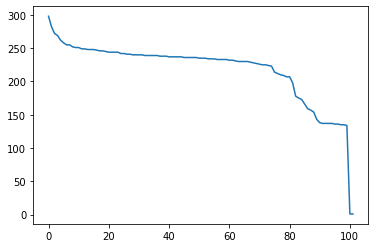

In [7]:
# Let's have a look to distribution 
l = list(Counter(list_label).values())
l.sort(reverse=True )
plt.plot( l )

In [8]:
def label_func(path_obj):
    return image_to_category[os.path.basename(path_obj)]

In [9]:
# default aug
aug = aug_transforms(mult=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip=True, # Random flipping
    flip_vert=False, # Flip vertically
    max_rotate=10., # Maximum degree of rotation
    min_zoom=1., # Minimum zoom 
    max_zoom=1.1, # Maximum zoom 
    max_lighting=0.2, # Maximum scale of changing brightness 
    max_warp=0.2, # Maximum value of changing warp per
    p_affine=0.75, # Probability of applying affine transformation
    p_lighting=0.75, # Probability of changing brightnest and contrast 
    xtra_tfms=None, # Custom Transformations
    size=None, # Output size, duplicated if one value is specified
    mode='bilinear', # PyTorch `F.grid_sample` interpolation
    pad_mode=PadMode.Reflection, # A `PadMode`
    align_corners=True, # PyTorch `F.grid_sample` align_corners
    batch=False, # Apply identical transformation to entire batch
    min_scale=1. # Minimum scale of the crop, in relation to image area)

SyntaxError: unexpected EOF while parsing (<ipython-input-9-da8a904665f8>, line 18)

In [10]:
aug = aug_transforms(
    mult=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip=True, # Random flipping
    flip_vert=True, # Flip vertically
    max_rotate=20., # Maximum degree of rotation
    min_zoom=0.9, # Minimum zoom 
    max_zoom=1.2, # Maximum zoom 
    max_lighting=0.3, # Maximum scale of changing brightness 
    max_warp=0.2, # Maximum value of changing warp per
    p_affine=0.75, # Probability of applying affine transformation
    p_lighting=0.75, # Probability of changing brightnest and contrast 
    xtra_tfms=None, # Custom Transformations
    size=None, # Output size, duplicated if one value is specified
    mode='bilinear', # PyTorch `F.grid_sample` interpolation
    pad_mode=PadMode.Reflection, # A `PadMode`
    align_corners=True, # PyTorch `F.grid_sample` align_corners
    batch=False, # Apply identical transformation to entire batch
    min_scale=1.) # Minimum scale of the crop, in relation to image area)

In [11]:
dls = ImageDataLoaders.from_name_func(path, split_file, label_func, item_tfms=Resize(256),bs=bs,batch_tfms=aug, seed=42, valid_pct=0.2)

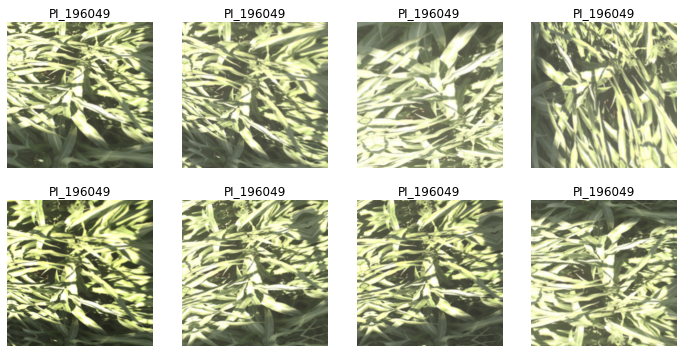

In [12]:
dls.show_batch(unique=True)

In [13]:
dls.bs, len(split_file)

(8, 22193)

In [14]:
from timm import *
from fastai.vision.all import *


In [15]:
arch = 'convnext_small_in22k'
#arch = 'resnet50'
learn = vision_learner(dls, arch, metrics=error_rate)
#learn.lr_find(suggest_funcs=(valley, slide))
#learn.fine_tune(50)

#default aug
#14	2.132918	3.053929	0.719457	00:41

In [16]:
learn.fine_tune(epochs=num_epoch,
    base_lr=0.001,
    freeze_epochs=num_epoch_freeze)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [35]:
tst_files = get_image_files("/home/remi/Documents/kaggle_data/test/").sorted()
tst_dl = dls.test_dl(tst_files)

In [22]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [23]:
list_df =[] 
list_cultivar =[] 

for i in tqdm(range(len(tst_files))):#    len(tst_files)):
    list_df.append(os.path.basename(tst_files[i]))
    list_cultivar.append(dls.vocab[idxs[i]])

import pandas as pd
d = {'filename': list_df, 'cultivar': list_cultivar}
df = pd.DataFrame(d)
df


100%|██████████| 23639/23639 [00:01<00:00, 14982.84it/s]


In [24]:
import pandas as pd
d = {'filename': list_df, 'cultivar': list_cultivar}
df = pd.DataFrame(d)
df

,filename,cultivar
0,1000005362.png,PI_180348
1,1000099707.png,PI_329333
2,1000135300.png,PI_266927
3,1000136796.png,PI_329256
4,1000292439.png,PI_155760
...,...,...
23634,999578153.png,PI_152728
23635,999692877.png,PI_273465
23636,999756998.png,PI_152733
23637,999892248.png,PI_152923


In [20]:
!pwd

/home/remi/Documents/Sorghum_kaggle_circleCI


In [30]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [31]:
error_rate(preds, targs)


TensorBase(0.7104)

In [32]:
tta_preds,_ = learn.tta(dl=valid, n=4, beta=0)#O.14 avec les paramètres par defaut 

In [33]:
error_rate(tta_preds, targs)

TensorBase(0.6787)

In [36]:
preds,_ = learn.tta(dl=tst_dl)
idxs = preds.argmax(dim=1)

In [37]:
idxs

tensor([20, 40, 49,  ..., 40, 18, 67])

In [39]:
list_df =[] 
list_cultivar =[] 

for i in tqdm(range(len(tst_files))):#    len(tst_files)):
    list_df.append(os.path.basename(tst_files[i]))
    list_cultivar.append(dls.vocab[idxs[i]])

import pandas as pd
d = {'filename': list_df, 'cultivar': list_cultivar}
df = pd.DataFrame(d)
df.to_csv('submissionRemiTTA.csv', index=False)
df

100%|██████████| 23639/23639 [00:01<00:00, 18661.25it/s]


,filename,cultivar
0,1000005362.png,PI_152965
1,1000099707.png,PI_156463
2,1000135300.png,PI_175919
3,1000136796.png,PI_196049
4,1000292439.png,PI_196049
...,...,...
23634,999578153.png,PI_152728
23635,999692877.png,PI_180348
23636,999756998.png,PI_156463
23637,999892248.png,PI_152923
